## Libraries loading

In [1]:
%matplotlib inline

In [2]:
import random
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

seed = 12345
random.seed(seed)
torch.manual_seed(seed)
print("Seed is set:", seed)

Seed is set: 12345


# Neural Style Transfer

In [3]:
IMSIZE = 256  

loader = transforms.Compose([
    transforms.Resize(IMSIZE),
    transforms.CenterCrop(IMSIZE),
    transforms.ToTensor()])

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(DEVICE, torch.float)


content_img = image_loader("images/dancing.jpg")
style_img = image_loader("images/picasso.jpg")

In [5]:
def get_mask_3d(input_, style_number = 1):
    
    # height == width always in this architecture
    batch_size, channels, height, width = input_.size()
        
    # Only one style for picture used
    if style_number == 0:
        mask_img_2d = torch.ones(height)
        
    # style for the lower left part of the picture
    elif style_number == 1:
        mask_img_2d = torch.eye(height)
        for h in range(height):
            for w in range(height):
                if mask_img_2d[h, w] == 1:
                    mask_img_2d[h, :w] = 1
                    break
                    
    # style for the upper right part of the picture
    elif style_number == 2:
        mask_img_2d = torch.eye(height)
        for h in range(height):
            for w in range(height):
                if mask_img_2d[h, w] == 1:
                    mask_img_2d[h, w:] = 1
                    break
    else:
        raise AttributeError("style_number should be 0, 1 or 2")
                
    mask_img_3d = torch.empty_like(input_, requires_grad=False)
    mask_img_3d[0, :] = mask_img_2d
                
    return mask_img_3d

In [6]:
mask_img = get_mask_3d(content_img, style_number=1)

In [7]:
unloader = transforms.ToPILImage()
def get_image(tensor):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    return image

In [8]:
def imshow(tensor, title=None):
    image = get_image(tensor)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [9]:
def show_images(content_img, style_img, mask_image=None):
    
    if mask_image is None:
        plt.figure(figsize=(10, 10))
        imgs = [content_img, style_img]
        title = ['Content Image', 'Style Image']
        for i in range(2):
            plt.subplot(1, 2, i + 1)
            plt.axis('off')
            plt.title(title[i])
            plt.imshow(get_image(imgs[i]))
        plt.show()
        return     
            
    plt.figure(figsize=(10, 20))
    imgs = [content_img, style_img, mask_image]
    title = ['Content Image', 'Style Image', 'Mask Image']
    
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.axis('off')
        plt.title(title[i])
        plt.imshow(get_image(imgs[i]))
        
    plt.show()
    return

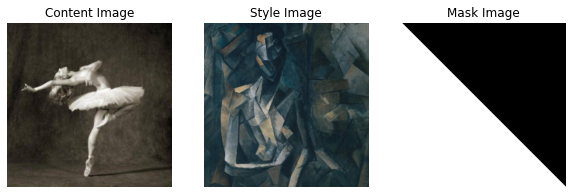

In [10]:
plt.ion() 
show_images(content_img, style_img, mask_img)

In [11]:
class ContentLoss(nn.Module):

        def __init__(self, target):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input_):
            self.loss = F.mse_loss(input_, self.target)
            return input_

In [12]:
def gram_matrix(input_):
        batch_size, c, h, w = input_.size()

        features = input_.view(batch_size * c, -1)

        G = torch.mm(features, features.t())

        return G.div(batch_size * c * h * w)

In [13]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature, mask_image):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.mask = mask_image.detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input_):
            b, c, h, w = input_.size()
            
            mask_img_2d = F.interpolate(self.mask, size=(h, w))[0, 0]
            mask_img_3d = torch.empty_like(input_, requires_grad=False)
            mask_img_3d[0, :] = mask_img_2d
            
            input_ = input_ * mask_img_3d
            
            G = gram_matrix(input_)
            self.loss = F.mse_loss(G, self.target)
            return input_

In [14]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

In [15]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = mean.view(-1, 1, 1)
            self.std = std.view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std

In [16]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

В качестве предобученной свёрточной нейросети возьмём VGG с 19 слоями.

In [17]:
cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval()

In [18]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [19]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img, mask_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        normalization = Normalization(normalization_mean, normalization_std).to(DEVICE)

        content_losses = []
        style_losses = []

        model = nn.Sequential(normalization)

        i = 0 
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature, mask_img)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # Now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [20]:
def get_input_optimizer(input_img):
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [21]:
model, style_losses, content_losses = get_style_model_and_losses(cnn,
                        cnn_normalization_mean, cnn_normalization_std, style_img, content_img, mask_img)

In [22]:
print(len(model))
model

18


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)

In [23]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, mask_img, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
    
        print('Building the style transfer model..')
        
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img, mask_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        input_img.data.clamp_(0, 1)

        return input_img

In [24]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, mask_img, input_img, num_steps=500)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.528097 Content Loss: 2.466477

run [100]:
Style Loss : 1.259700 Content Loss: 1.806332

run [150]:
Style Loss : 1.191459 Content Loss: 1.688177

run [200]:
Style Loss : 1.167703 Content Loss: 1.646546

run [250]:
Style Loss : 1.155646 Content Loss: 1.627224

run [300]:
Style Loss : 1.148457 Content Loss: 1.618158

run [350]:
Style Loss : 1.174638 Content Loss: 1.606232

run [400]:
Style Loss : 1.138384 Content Loss: 1.614299

run [450]:
Style Loss : 1.145921 Content Loss: 1.617833

run [500]:
Style Loss : 1.180257 Content Loss: 1.622698



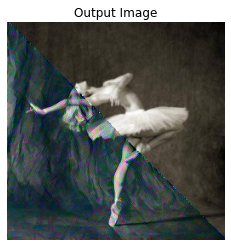

In [25]:
imshow(output, title='Output Image')

In [26]:
style_img = image_loader("images/kandinsky.jpg")
mask_img = get_mask_3d(content_img, style_number=2)

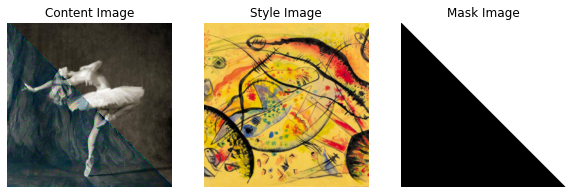

In [27]:
show_images(output, style_img, mask_img)

In [28]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, mask_img, output, num_steps=500)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 52.403625 Content Loss: 22.667353

run [100]:
Style Loss : 31.894003 Content Loss: 22.107471

run [150]:
Style Loss : 21.340277 Content Loss: 21.514122

run [200]:
Style Loss : 13.928665 Content Loss: 21.257507

run [250]:
Style Loss : 10.838855 Content Loss: 20.803022

run [300]:
Style Loss : 9.907027 Content Loss: 20.251801

run [350]:
Style Loss : 9.559215 Content Loss: 19.920843

run [400]:
Style Loss : 9.249562 Content Loss: 19.691826

run [450]:
Style Loss : 9.106394 Content Loss: 19.538155

run [500]:
Style Loss : 10.100327 Content Loss: 19.168285



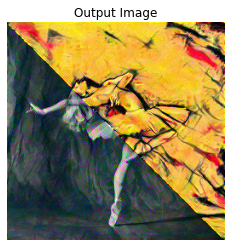

In [29]:
imshow(output, title='Output Image')

# One Style Transformation

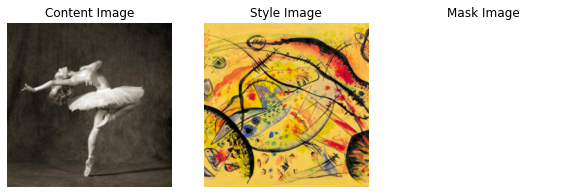

In [36]:
mask_img = get_mask_3d(content_img, style_number=0)
show_images(content_img, style_img, mask_img)

In [37]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, mask_img, input_img, num_steps=500)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 127.278572 Content Loss: 54.557533

run [100]:
Style Loss : 36.849144 Content Loss: 52.342663

run [150]:
Style Loss : 19.398933 Content Loss: 48.929726

run [200]:
Style Loss : 12.084209 Content Loss: 46.325184

run [250]:
Style Loss : 6.554508 Content Loss: 44.718655

run [300]:
Style Loss : 4.201520 Content Loss: 43.199493

run [350]:
Style Loss : 3.105194 Content Loss: 42.005592

run [400]:
Style Loss : 2.849077 Content Loss: 40.927048

run [450]:
Style Loss : 2.398428 Content Loss: 40.165138

run [500]:
Style Loss : 2.173090 Content Loss: 39.470112



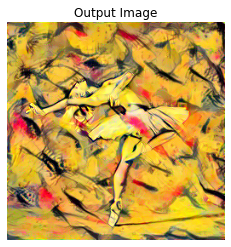

In [38]:
imshow(output, title='Output Image')